In [1]:
import os
import shutil
import h5py
import random
import glob
import argparse
import numpy as np
from astropy.nddata.utils import Cutout2D
from shutil import copyfile
from astropy.io import fits
import pandas as pd
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.wcs.utils import skycoord_to_pixel
import warnings
import time
from astropy.table import Table

In [2]:
def make_cutout(img, x, y):
    ''' Creates the image cutout given a tile, the position of the center and the band '''

    img_cutout = Cutout2D(img.data, (x, y), cutout_size, mode="partial", fill_value=0).data

    if np.count_nonzero(np.isnan(img_cutout)) >= 0.05 * cutout_size ** 2 or np.count_nonzero(
            img_cutout) == 0:  # Don't use this cutout
        return np.zeros((cutout_size, cutout_size))

    img_cutout[np.isnan(img_cutout)] = 0

    return img_cutout


def ra_dec_to_xy(fits, ra, dec, band):
    if band in ['i', 'z']:
        head = fits[1].read_header()
    else:
        head = fits[0].read_header()
    w = WCS(head)
    return skycoord_to_pixel(SkyCoord(ra, dec, unit="deg"), w)

def show_scale(fits_file):
    hdulist = fits.open(fits_file) #open fits file
    if (file.split('.')[-2] in ['z'] or file.split('/')[-1].startswith('calexp')):
        exp = 1
    else:
        exp = 0
    header = hdulist[exp].header #get header of first extension
    wcs = WCS(header)
    ra = header['CRVAL1']
    dec = header['CRVAL2']
    pix_scale = abs(header['CD1_1']*3600)
    dim_x_deg = header['NAXIS1']*pix_scale/3600
    dim_y_deg = header['NAXIS2']*pix_scale/3600
    return ra, dec, pix_scale, dim_x_deg, dim_y_deg

def union_catalogs(cat1, cat2, r=15.0, ra_key='RAJ2000', dec_key='DEJ2000'):
    cat1, cat2 = (cat1, cat2) if len(cat1) <= len(cat2) else (cat2, cat1)
    c_cat1 = SkyCoord(cat1[ra_key], cat1[dec_key], unit='deg', frame='icrs')
    c_cat2 = SkyCoord(cat2[ra_key], cat2[dec_key], unit='deg', frame='icrs')
    
    max_sep = r * units.arcsec
    idx, d2d, d3d = c_cat1.match_to_catalog_3d(c_cat2)
    sep_constraint = d2d < max_sep
    cat1_matches = cat1.loc[sep_constraint]
    cat1_unmatches = cat1.loc[~sep_constraint]    
    
    cat_new = pd.concat([cat1_unmatches, cat2], ignore_index=True)
    
    return cat_new

def kpc_to_arcsec(kpc, D):
    radians = kpc/(1000*D)
    arcsec = np.degrees(radians)*3600
    return arcsec
    
def arcsec_to_kpc(arcsec, D):
    radians = np.radians(arcsec/3600)
    return radians*D*1000

In [3]:
file_path = '/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/fields/CFIS_LSB.246.289.r/'
fits_file_g = 'calexp-CFIS_246_289.fits'
fits_file_u = 'CFIS.246.289.u.fits'
fits_file_r = 'CFIS_LSB.246.289.r.fits'
fits_file_z = 'WISHES.246.289.z.fits'
fits_file_i = 'PS-DR3.246.289.i.fits'

In [4]:
tables = '/home/nick/astro/TileSlicer/tables/'
matlas = pd.read_csv(tables + 'matlas_info.csv')
elves = pd.read_csv(tables + 'elves_info.csv')
elves['re_arc'] = [kpc_to_arcsec(x/1000., D) for x, D in zip(elves['re'], elves['dist'])]
M101_lsb = pd.read_csv(tables + 'M101_lsb.csv')
M101_lsb['morph'] = 'UDG'
smudges = Table.read(tables+'smudges.fits', format='fits')
smudges = smudges.to_pandas()
smudges = smudges.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
smudges.to_csv(tables+'smudges.csv', index=False)
dE_catalog = Table.read(tables+'dE_catalog.fits', format='fits')
dE_catalog = dE_catalog.to_pandas()
dE_catalog = dE_catalog.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
dE_catalog['PGC'] = ['PGC'+str(x) for x in np.array(dE_catalog['PGC'])]
dE_catalog.to_csv(tables+'dE_catalog.csv', index=False)

In [22]:
start = time.time()
np.count_nonzero(matlas['f_Dist'] == 1)
print(f'Done in {time.time()-start} seconds.')

Done in 0.0002186298370361328 seconds.


In [8]:
matlas['f_Dist'].values()

TypeError: 'numpy.ndarray' object is not callable

In [138]:
# Define column names based on the byte-by-byte description
columns = [
    'Name', 'RAdeg', 'DEdeg', 'Host', 'Dist-host', 'Dist-SBF', 'Source',
    'Confirm', 'vrec', 'r_vrec', 'Dtrgb', 'r_Dtrgb']

# Read the data into a pandas DataFrame
elves_rejected = pd.read_fwf(tables+ 'elves_rejected.csv', skiprows=0, header=None, names=columns)

In [5]:
dE_fuse = dE_catalog[['PGC','ID','RAdeg','DEdeg','ARh','Class','z']].rename(columns={'PGC':'host','RAdeg':'ra','DEdeg':'dec','ARh':'re','Class':'morph'})
replacements = {
    'ND': 'dE',
    'UD': 'UDG',
}
dE_fuse['morph'].replace(replacements, inplace=True)
dE_fuse['z'].replace(9.9999, np.nan, inplace=True)

matlas_fuse = matlas[['HostETG','ID','RAdeg','DEdeg','Morph','Re']].rename(columns={'HostETG':'host','RAdeg':'ra','DEdeg':'dec','Morph':'morph','Re':'re'})
elves_fuse = elves[['host','name','radeg','dedeg', 're_arc']].rename(columns={'name':'ID','radeg':'ra','dedeg':'dec', 're_arc':'re'})
M101_fuse = M101_lsb[['host','ID','ra','dec', 'morph','re']]
matlas_elves = union_catalogs(matlas_fuse, elves_fuse, ra_key='ra', dec_key='dec')
matlas_elves = union_catalogs(matlas_elves, M101_fuse, ra_key='ra', dec_key='dec')
matlas_elves_dE = union_catalogs(matlas_elves, dE_fuse, ra_key='ra', dec_key='dec')
matlas_elves_dE.to_csv(tables+'all_known_dwarfs.csv', index=False)
matlas_elves.to_csv(tables+'known_dwarfs.csv', index=False)

<Axes: >

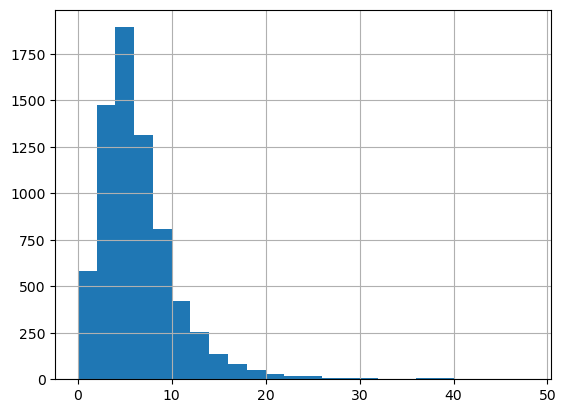

In [6]:
tables = '/home/nick/astro/TileSlicer/tables/'
known_dwarfs = pd.read_csv(tables+'known_dwarfs_processed.csv')
bins = np.arange(0, 50, 2)
known_dwarfs['re'].hist(bins=bins)

In [7]:
known_dwarfs_3b = known_dwarfs.loc[known_dwarfs['n_bands'] >= 3]

In [10]:
median = known_dwarfs_3b['re'].loc[known_dwarfs_3b['re'] > 0].median()
mean = known_dwarfs_3b['re'].loc[known_dwarfs_3b['re'] > 0].mean()

pix_median, pix_mean = median/pix_scale, mean/pix_scale

print(f'The median half light diameter in pixels is {pix_median*2}, the mean is {pix_mean*2}')

The median half light diameter in pixels is 56.52197747492921, the mean is 78.09731974165071


In [9]:
file = os.path.join(file_path,fits_file_u)
_, _, pix_scale, _, _ = show_scale(file)

In [5]:
file = os.path.join(file_path,fits_file_g)
show_scale(file)

(211.812250635808,
 54.5,
 0.1857684474089298,
 0.516023465024805,
 0.516023465024805)

In [6]:
file = os.path.join(file_path,fits_file_r)
show_scale(file)

(211.81225064, 54.5, 0.185768447408928, 0.5160234650248, 0.5160234650248)

In [7]:
file = os.path.join(file_path,fits_file_i)
show_scale(file)

(211.81225064, 54.5, 0.185768447408928, 0.5160234650248, 0.5160234650248)

In [8]:
file = os.path.join(file_path,fits_file_z)
show_scale(file)

(211.812250635808,
 54.5,
 0.18576844740891937,
 0.516023465024776,
 0.516023465024776)

## Relate ra, dec to tile numbers

In [6]:
def relate_coord_tile(coords=None, nums=None):
    """
    Conversion between tile numbers and coordinates.
    :param coords: right ascention, declination; tuple
    :param nums: first and second tile numbers; tuple
    :return: depending on the input, return the tile numbers or the ra and dec coordinates
    """
    if coords:
        ra, dec = coords
        xxx=ra*2*np.cos(np.radians(dec))
        yyy=(dec+90)*2
        return int(xxx), int(yyy)
    else:
        xxx, yyy = nums
        dec=yyy/2-90
        ra=xxx/2/np.cos(np.radians(dec))
        return np.round(ra,12), np.round(dec,12)

## Get lists of currently available tiles for each band

In [7]:
def update_available_tiles(path, save=True):
    """
    Update available tile lists from the VOSpace. Takes a few mins to run.
    :param path: path to save tile lists.
    :param save: save new lists to disk, default is True.
    :return: /
    """
    cfis_u_tiles = client.glob1('vos:cfis/tiles_DR5/','*u.fits')
    whigs_g_tiles = client.glob1('vos:cfis/whigs/stack_images_CFIS_scheme/','*.fits')
    cfis_lsb_r_tiles = client.glob1('vos:cfis/tiles_LSB_DR5/','*.fits')
    ps_i_tiles = client.glob1('vos:cfis/panstarrs/DR3/tiles/','*i.fits')
    wishes_z_tiles = client.glob1('vos:cfis/wishes_1/coadd/','*.fits')
    if save:
        np.savetxt(path+'cfis_u_tiles.txt', cfis_u_tiles, fmt='%s')
        np.savetxt(path+'whigs_g_tiles.txt', whigs_g_tiles, fmt='%s')
        np.savetxt(path+'cfis_lsb_r_tiles.txt', cfis_lsb_r_tiles, fmt='%s')
        np.savetxt(path+'ps_i_tiles.txt', ps_i_tiles, fmt='%s')
        np.savetxt(path+'wishes_z_tiles.txt', wishes_z_tiles, fmt='%s')
        
def load_available_tiles(path):
    """
    Load tile lists from disk.
    :param path: path to files
    :return: lists of available tiles for the five bands
    """
    u_tiles = np.loadtxt(path+'cfis_u_tiles.txt', dtype=str)
    g_tiles = np.loadtxt(path+'whigs_g_tiles.txt', dtype=str)
    lsb_r_tiles = np.loadtxt(path+'cfis_lsb_r_tiles.txt', dtype=str)
    i_tiles = np.loadtxt(path+'ps_i_tiles.txt', dtype=str)
    z_tiles = np.loadtxt(path+'wishes_z_tiles.txt', dtype=str)
    
    return u_tiles, g_tiles, lsb_r_tiles, i_tiles, z_tiles

def get_tile_numbers(name):
    """
    Extract tile numbers from tile name
    :param name: .fits file name of a given tile
    :return two three digit tile numbers
    """
    parts = name.split('.')
    if name.startswith('calexp'):
        parts = parts[0].split('_')
    xxx, yyy = map(int, parts[1:3])
    return xxx, yyy

def extract_tile_numbers(tile_lists):
    """
    Extract tile numbers from .fits file names.
    :param tile_lists: lists of file names from the different bands
    :return: lists of tile numbers available in the different bands
    """
    u_nums = np.array([get_tile_numbers(name) for name in tile_lists[0]])
    g_nums = np.array([get_tile_numbers(name) for name in tile_lists[1]])
    lsb_r_nums = np.array([get_tile_numbers(name) for name in tile_lists[2]])
    i_nums = np.array([get_tile_numbers(name) for name in tile_lists[3]])
    z_nums = np.array([get_tile_numbers(name) for name in tile_lists[4]])
    
    return u_nums, g_nums, lsb_r_nums, i_nums, z_nums

class TileAvailability:
    def __init__(self, tile_nums, band_dict, at_least=False, band=None):
        self.all_tiles = tile_nums
        self.tile_num_sets = [set(map(tuple, tile_array)) for tile_array in self.all_tiles]
        self.unique_tiles = sorted(set.union(*self.tile_num_sets))
        self.availability_matrix = self._create_availability_matrix()
        self.counts = self._calculate_counts(at_least)
        self.band_dict = band_dict

    def _create_availability_matrix(self):
        array_shape = (len(self.unique_tiles), len(self.all_tiles))
        availability_matrix = np.zeros(array_shape, dtype=int)

        for i, tile in enumerate(self.unique_tiles):
            for j, tile_num_set in enumerate(self.tile_num_sets):
                availability_matrix[i, j] = int(tile in tile_num_set)

        return availability_matrix

    def _calculate_counts(self, at_least):
        counts = np.sum(self.availability_matrix, axis=1)
        bands_available, tile_counts = np.unique(counts, return_counts=True)

        counts_dict = dict(zip(bands_available, tile_counts))
        
        if at_least:
            at_least_counts = np.zeros_like(bands_available)
            for i, count in enumerate(bands_available):
                at_least_counts[i] = np.sum(tile_counts[i:])
            counts_dict = dict(zip(bands_available, at_least_counts))
        
        return counts_dict

    def get_availability(self, tile_number):
        try:
            index = self.unique_tiles.index(tuple(tile_number))
        except:
            print('\nTile number not available in any band.')
            return [] , []
        bands_available = np.where(self.availability_matrix[index] == 1)[0]
        return [self.band_dict[list(self.band_dict.keys())[i]]['band'] for i in bands_available], bands_available

    def band_tiles(self, band):
        return np.array(self.unique_tiles)[self.availability_matrix[:,list(self.band_dict.keys()).index(band)] == 1]

    def stats(self):
        print("\nNumber of currently available tiles per band:\n")
        max_band_name_length = max(map(len, self.band_dict.keys()))  # for output format
        for band_name, count in zip(self.band_dict.keys(), np.sum(self.availability_matrix, axis=0)):
            print(f"{band_name.ljust(max_band_name_length)}: \t {count}")
        
        print("\nNumber of tiles available in different bands:\n")
        for bands_available, count in sorted(self.counts.items(), reverse=True):
            print(f"In {bands_available} bands: {count}")
            
        print('\nNumber of unique tiles available:\n\n' \
             f'{len(self.unique_tiles)}')

In [8]:
from vos import Client
client = Client()

band_dict = {'cfis-u': {'name': 'CFIS', 'band': 'u', 'vos': 'vos:cfis/tiles_DR5/', 'suffix': '.u.fits', 'delimiter': '.', 'fits_ext': 0, 'zfill': 3},
            'whigs-g': {'name': 'calexp-CFIS', 'band': 'g', 'vos': 'vos:cfis/whigs/stack_images_CFIS_scheme/', 'suffix': '.fits', 'delimiter': '_', 'fits_ext': 1, 'zfill': 0},
            'cfis_lsb-r': {'name': 'CFIS_LSB', 'band': 'r', 'vos': 'vos:cfis/tiles_LSB_DR5/', 'suffix': '.r.fits', 'delimiter': '.', 'fits_ext': 0, 'zfill': 3},
            'ps-i': {'name': 'PS-DR3', 'band': 'i', 'vos': 'vos:cfis/panstarrs/DR3/tiles/', 'suffix': '.i.fits', 'delimiter': '.', 'fits_ext': 0, 'zfill': 3},
            'wishes-z': {'name': 'WISHES', 'band': 'z', 'vos': 'vos:cfis/wishes_1/coadd/', 'suffix': '.z.fits', 'delimiter': '.', 'fits_ext': 1, 'zfill': 0}}

parent_dir = '/home/nick/astro/TileSlicer/'
tile_dir = os.path.join(parent_dir, 'tile_info/')
os.makedirs(tile_dir, exist_ok=True)
# retrieve from the VOSpace and update the currently available tiles
# takes some time to run
update = False
# return the number of available tiles that are available in at least 5, 4, 3, 2, 1 bands
at_least = False

if update:
    update_available_tiles(tile_dir)
    
u, g, lsb_r, i, z = extract_tile_numbers(load_available_tiles(tile_dir))
all_bands = [u, g, lsb_r, i, z]
availability = TileAvailability(all_bands, band_dict, at_least)
availability.stats()

# Check the availability for a specific tile
tile_number = (243, 290)
tile_coords = relate_coord_tile(nums=tile_number)
avail_bands = availability.get_availability(tile_number)
print(f'\n{avail_bands}')


Number of currently available tiles per band:

cfis-u    : 	 34017
whigs-g   : 	 19528
cfis_lsb-r: 	 20802
ps-i      : 	 22168
wishes-z  : 	 8444

Number of tiles available in different bands:

In 5 bands: 5229
In 4 bands: 9984
In 3 bands: 5007
In 2 bands: 3418
In 1 bands: 17021

Number of unique tiles available:

40659

(['u', 'g', 'r', 'i', 'z'], array([0, 1, 2, 3, 4]))


## Create KD-Tree from tile list

In [9]:
from scipy.spatial import cKDTree
import joblib

def tile_coordinates(name):
    """
    Extract RA and Dec from tile name
    :param name: .fits file name of a given tile
    :return RA and Dec of the tile center
    """
    parts = name.split('.')
    if name.startswith('calexp'):
        parts = parts[0].split('_')
    xxx, yyy = map(int, parts[1:3])
    ra = np.round(xxx / 2 / np.cos(np.radians((yyy / 2) - 90)),6)
    dec = np.round((yyy / 2) - 90,6)
    return ra, dec
    
def build_tree(tiles, path, save=True):
    """
    Build a kd tree from the input tiles to efficiently query object positions.
    :param tiles: list of unique tile number pairs
    :param save: save the built tree to file
    :return: /
    """
    tile_coords = np.array([relate_coord_tile(nums=num) for num in tiles])
    tile_coords_c = SkyCoord(tile_coords[:,0], tile_coords[:,1], unit='deg', frame='icrs')
    tile_coords_xyz = np.array([x.cartesian.xyz.value for x in tile_coords_c])
    tree = cKDTree(tile_coords_xyz)
    if save:
        joblib.dump(tree, path+'kdtree_xyz.joblib')

def query_tree(tiles, coords, path, build=False, save=True):
    """
    Query the kd tree to find what tile an object is in.
    :param tiles: list of tile numbers as tuples
    :param coords: ra, dec of object to query
    :build: if true build the tree first, default=False
    :return tile name and distance object - nearest tile center
    """
    if build:
        build_tree(tiles, path, save)
    loaded_tree = joblib.load(path+'kdtree_xyz.joblib')
    try:
        tile_name, dist = find_tile(loaded_tree, tiles, coords)
        return tile_name, dist
    except ValueError as e:
        return np.nan, f'Error: {e}'

class TileWCS:
    def __init__(self, wcs_keywords={}):
        wcs_keywords.update({
                'NAXIS': 2,
                'CTYPE1': 'RA---TAN',
                'CTYPE2': 'DEC--TAN',
                'CRVAL1': 0,
                'CRVAL2': 0,
                'CRPIX1': 5000.0,
                'CRPIX2': 5000.0,
                'CD1_1': -5.160234650248e-05,
                'CD1_2': 0.0,
                'CD2_1': 0.0,
                'CD2_2': 5.160234650248e-05,
                'NAXIS1': 10000,
                'NAXIS2': 10000
        })
            
        self.wcs = WCS(wcs_keywords)

    def set_coords(self, coords):
        self.wcs.wcs.crval = [coords[0], coords[1]]
        
def find_tile(tree, tiles, object_coord):
    """
    Query the tree and find the tile the object is in.
    :param tree: kd tree
    :param tiles: list of unique tiles in the survey
    :param object_coord: coordinates of the object we want to find a tile for
    :return: tile numbers of the matching tile
    """
    coord_c = SkyCoord(object_coord[0], object_coord[1], unit='deg', frame='icrs')
    coord_xyz = coord_c.cartesian.xyz.value
    dists, indices = tree.query(coord_xyz, k=4)
    wcs = TileWCS()
    for dist, idx in zip(dists,indices):
        wcs.set_coords(relate_coord_tile(nums=tiles[idx]))
        if wcs.wcs.footprint_contains(coord_c):
            return tiles[idx], dist
    raise ValueError('Object could not be assigned to a tile.')

In [8]:
tiles = availability.unique_tiles
obj_coord = 134.5670522, 85.2508887
obj_coord_c = SkyCoord(obj_coord[0], obj_coord[1], unit='deg', frame='icrs')
tile_numbers, dist_nn = query_tree(tiles, obj_coord, path, build=False)
if dist_nn:
    center_coord = relate_coord_tile(nums=tile_numbers)
    center_coord_c = SkyCoord(center_coord[0], center_coord[1], unit='deg', frame='icrs')
    sep_skycoord = obj_coord_c.separation(center_coord_c).deg
    sep_tree = np.degrees(dist_nn)
    print(f'The object is in tile number {tile_numbers}.')
    print(f'The distance to the nearest tile center is {np.round(np.degrees(dist_nn),3)} degrees.')
# print(f'Distance skycoord: {sep_skycoord}, distance tree: {sep_tree}')

NameError: name 'path' is not defined

## Download a specific tile

### Test client speed

In [17]:
start_time = time.time()
file_name = 'CFIS_LSB.143.900.r.fits'
client.copy(f'vos:cfis/tiles_LSB_DR5/{file_name}', f'/home/nick/astro/ssl-spencer/{file_name}')
print(f'Finished download. Took {(time.time()-start_time)/60} minutes')

NameError: name 'time' is not defined

### Test command line speed

In [113]:
start_time = time.time()
file_name = 'CFIS_LSB.143.321.r.fits'
vos_copy_command = f'vcp -v vos:cfis/tiles_LSB_DR5/{file_name}'
os.system(vos_copy_command + f' /home/nick/astro/ssl-spencer/temp_dir/{file_name}')
print(f'Finished download. Took {(time.time()-start_time)/60} minutes')

INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.143.321.r.fits -> /home/nick/astro/ssl-spencer/temp_dir/CFIS_LSB.143.321.r.fits 


Finished download. Took 12.658307552337646 minutes


# Pipeline outline

In [10]:
cat_dir = '/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/'
catalog = pd.read_csv(cat_dir+'NGC5485_dwarfs.csv')
ra_key, dec_key = 'ra', 'dec'
coord_c = SkyCoord(catalog[ra_key].values, catalog[dec_key].values, unit='deg', frame='icrs')

In [56]:
def read_unions_cat(unions_table_dir, tile_nums):
    """
    Read UNIONS catalog from disk.

    Args:
        unions_table_dir (str): directory where the UNIONS catalogs are located
        tile_nums (list): list of tile numbers

    Returns:
        cat (dataframe): pandas dataframe containing the UNIONS catalog for the specified tile
    """
    columns = ['SeqNr', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000','MAG_GAAP_r']
    df = Table.read(
        os.path.join(
            unions_table_dir,
            f'UNIONS.{tile_nums[0]}.{tile_nums[1]}',
            f'UNIONS.{tile_nums[0]}.{tile_nums[1]}_ugri_photoz_ext.cat'), hdu=1).to_pandas()
    df = df[columns].rename(columns={'SeqNr':'ID','X_IMAGE':'x','Y_IMAGE':'y','ALPHA_J2000':'ra','DELTA_J2000':'dec','MAG_GAAP_r':'mag_r'})
    df['tile'] = str(tile_nums)
    return df

In [57]:
unions_table_dir = tables
tile_nums = (312, 249)
unions_cat = read_unions_cat(unions_table_dir, tile_nums)

In [58]:
unions_cat

,ID,x,y,ra,dec,mag_r,tile
0,1,5867.558594,331.374786,189.237235,34.259077,19.594919,"(312, 249)"
1,2,7891.011719,226.785400,189.110914,34.253560,19.907169,"(312, 249)"
2,3,2360.232666,126.855202,189.456190,34.248426,19.960625,"(312, 249)"
3,4,3491.770264,115.685303,189.385552,34.247923,20.141779,"(312, 249)"
4,5,6529.760742,95.740402,189.195905,34.246893,20.055593,"(312, 249)"
...,...,...,...,...,...,...,...
40006,40007,2768.404785,9880.113281,189.431554,34.751743,24.843489,"(312, 249)"
40007,40008,6845.988770,9831.000000,189.175468,34.749234,25.466747,"(312, 249)"
40008,40009,8849.885742,9985.469727,189.049596,34.757021,-99.000000,"(312, 249)"
40009,40010,68.660301,9799.685547,189.601091,34.747281,25.161900,"(312, 249)"


In [5]:
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import pyarrow.compute as pc

tables = '/home/nick/astro/TileSlicer/tables/'

### pandas read_parquet

In [8]:
start = time.time()
redshift_file = 'redshifts-2024-01-04.parquet'
ra_range = [211., 212.]
dec_range = [55., 57.]
parquet_path = os.path.join(tables, redshift_file)
filter_coords = [('ra','>=',ra_range[0]),('ra','<',ra_range[1]),('dec','>=',dec_range[0]),('dec','<',dec_range[1])]
redshift_cat = pd.read_parquet(parquet_path, engine='pyarrow', filters=filter_coords)
print(f'Time: {np.round(time.time() - start, 4)} seconds.')

Time: 0.8121 seconds.


### pyarrow.parquet read_parquet, memory_map = True

In [73]:
start = time.time()
redshift_file = 'redshifts-2024-01-04.parquet'
columns = ['ra', 'dec']
ra_range = [0., 300.]
dec_range = [0., 50.]

parquet_path = os.path.join(tables, redshift_file)
filter_coords = [('ra','>=',ra_range[0]),('ra','<',ra_range[1]),('dec','>=',dec_range[0]),('dec','<',dec_range[1])]
redshift_cat = pq.read_table(parquet_path, memory_map=True).to_pandas()
print(f'Time: {np.round(time.time() - start, 4)} seconds.')

Time: 0.5451 seconds.


In [76]:
redshift_cat.columns

Index(['ra', 'dec', 'cspec', 'zspec', 'zspec_err'], dtype='object')

In [92]:
redshift_cat.loc[redshift_cat['zspec'] == 0]

,ra,dec,cspec,zspec,zspec_err
121485,32.558833,-5.160108,1.0,0.0,0.000000
121886,32.158241,-4.246304,1.0,0.0,0.000068
123165,31.209650,-4.404062,1.0,0.0,0.000065
127802,35.037088,-5.922432,2.0,0.0,0.000000
172112,133.487656,8.900299,2.0,0.0,0.004430
...,...,...,...,...,...
55098534,39.964591,-1.547017,NaN,0.0,0.000000
55098535,39.963721,-1.561464,NaN,0.0,0.000000
55098536,39.970584,-1.597320,NaN,0.0,0.000000
55098537,39.973400,-1.598841,NaN,0.0,0.000000


In [83]:
redshift_cat

,ra,dec,cspec,zspec,zspec_err
0,24.837864,31.987288,2.0,0.373586,0.0
1,24.834875,32.031507,2.0,0.783066,0.0
2,24.291261,31.900061,1.0,0.000045,0.0
3,24.347372,31.805734,2.0,1.071963,0.0
4,24.270095,31.874742,2.0,0.812852,0.0
...,...,...,...,...,...
55225810,320.101000,-63.718700,NaN,0.021837,0.0
55225811,13.091700,31.442220,NaN,0.015593,0.0
55225812,118.893000,29.173060,NaN,0.021234,0.0
55225813,133.058000,1.460280,NaN,0.204486,0.0


### pyarrow.parquet read_parquet, memory_map = False

In [10]:
start = time.time()
redshift_file = 'redshifts-2024-01-04.parquet'
columns = ['ra', 'dec']
ra_range = [211., 215.]
dec_range = [55., 57.]

parquet_path = os.path.join(tables, redshift_file)
filter_coords = [('ra','>=',ra_range[0]),('ra','<',ra_range[1]),('dec','>=',dec_range[0]),('dec','<',dec_range[1])]
redshift_cat = pq.read_table(parquet_path, memory_map=False, filters=filter_coords).to_pandas()
print(f'Time: {np.round(time.time() - start, 4)} seconds.')

Time: 0.5356 seconds.


In [10]:
# catalog_dir = os.path.join(parent_dir, 'tables/')
# os.makedirs(catalog_dir, exist_ok = True)
# catalog = pd.read_csv(catalog_dir+'df_coordinates.csv')
# ra_key, dec_key = 'ra', 'dec'
# coord_c = SkyCoord(catalog[ra_key].values, catalog[dec_key].values, unit='deg', frame='icrs')

### Get a list of tiles the objects are in

In [11]:
import time
start_time = time.time()
# list tiles the objects are in
# update_available_tiles(path)
u, g, lsb_r, i, z = extract_tile_numbers(load_available_tiles(tile_dir))
all_bands = [u, g, lsb_r, i, z]
availability = TileAvailability(all_bands, band_dict)
tiles = availability.unique_tiles

def tile_finder(availability, catalog, band_constraint=5):
    available_tiles = availability.unique_tiles
    all_tiles = np.empty(len(catalog), dtype=tuple)
    pix_coords = np.empty((len(catalog),2), dtype=np.float64)
    for i , obj_coord in enumerate(coord_c):
        tile_numbers, _ = query_tree(available_tiles, np.array([obj_coord.ra.deg, obj_coord.dec.deg]), tile_dir, build=False)
        all_tiles[i] = tile_numbers
        wcs = TileWCS()
        wcs.set_coords(relate_coord_tile(nums=tile_numbers))
        pix_coord = skycoord_to_pixel(obj_coord, wcs.wcs, origin=1)
        pix_coords[i] = pix_coord

    # add tile numbers and pixel coordinates to catalog
    catalog['tile'] = all_tiles
    catalog['x'] = pix_coords[:,0]
    catalog['y'] = pix_coords[:,1]
    unique_tiles = list(set(all_tiles))
    tiles_x_bands = [tile for tile in unique_tiles if len(availability.get_availability(tile)) == band_constraint]
    
    return unique_tiles, tiles_x_bands

unique_tiles, tiles_x_bands = tile_finder(availability, catalog, band_constraint=5)

print(f'Time: {np.round(time.time()-start_time,3)}')

Time: 0.364


### Only keep tiles that are available in five bands

In [12]:
tiles_x_bands = [tile for tile in unique_tiles if len(availability.get_availability(tile)[1]) >= 3]

### Download the selected tiles

In [28]:
import time
from vos import Client
client = Client()


def download_tile_for_bands(availability, tile_numbers, in_dict, download_dir, method='api'):
    """
    Download a tile for the available bands.
    :param availability: object to retrieve available tiles
    :param tile_numbers: 2 three digit tile numbers
    :param in_dict: band dictionary containing the necessary info on the file properties
    :param download_dir: download directory
    :param method: choose between 'command' and 'api' for command line and client interaction with the VOSpace
    :return: True/False if the download was successful/failed
    """
    avail_idx = availability.get_availability(tile_numbers)[1]
    for band in np.array(list(band_dict.keys()))[avail_idx]:
        vos_dir = in_dict[band]['vos']
        prefix = in_dict[band]['name']
        suffix = in_dict[band]['suffix']
        delimiter = in_dict[band]['delimiter']
        digit_fill = in_dict[band]['digit_fill']
        if digit_fill:
            tile_dir = download_dir + f'{tile_numbers[0].zfill(3)}_{tile_numbers[1].zfill(3)}'
        os.makedirs(tile_dir, exist_ok=True)
        tile_fitsfilename = (
            f'{prefix}{delimiter}{tile_numbers[0]}{delimiter}{tile_numbers[1]}{suffix}'
        )
        # use a temporary name while the file is downloading
        temp_name = '.'.join(tile_fitsfilename.split('.')[:-1]) + '_temp.fits'

        # Check if the directory exists, and create it if not
        if os.path.exists(os.path.join(tile_dir, tile_fitsfilename)):
            print(f'File {tile_fitsfilename} was already downloaded.')
        else:
            print(f'Downloading {tile_fitsfilename}..')
            try:
                if method == 'command':
                    # command line
                    os.system(
                        f'vcp -v {vos_dir + tile_fitsfilename} {os.path.join(tile_dir, temp_name)}'
                    )
                else:
                    # API
                    client.copy(
                        os.path.join(vos_dir, tile_fitsfilename), os.path.join(tile_dir, temp_name)
                    )
                os.rename(
                    os.path.join(tile_dir, temp_name), os.path.join(tile_dir, tile_fitsfilename)
                )
            except Exception as e:
                print(e)
                return False
    return True


start = time.time()

download_dir = os.path.join(parent_dir, 'data_test/')
os.makedirs(download_dir, exist_ok=True)
for tile in tiles_x_bands:
    if download_tile_for_bands(availability, tile, band_dict, download_dir, method='command'):
        print(f'Files downloaded. Took {(time.time()-start)/60} minutes.')

## Download all 5 bands simultaneously

In [32]:
import os
import time
from concurrent.futures import ThreadPoolExecutor
from vos import Client
import numpy as np

client = Client()

def download_tile_for_band(tile_numbers, band, in_dict, download_dir, method='api'):
    vos_dir = in_dict[band]['vos']
    prefix = in_dict[band]['name']
    suffix = in_dict[band]['suffix']
    delimiter = in_dict[band]['delimiter']
    tile_dir = download_dir + f'{tile_numbers[0]}_{tile_numbers[1]}'
    os.makedirs(tile_dir, exist_ok=True)
    tile_fitsfilename = (
        f'{prefix}{delimiter}{tile_numbers[0]}{delimiter}{tile_numbers[1]}{suffix}'
    )
    temp_name = '.'.join(tile_fitsfilename.split('.')[:-1]) + '_temp.fits'

    if os.path.exists(os.path.join(tile_dir, tile_fitsfilename)):
        print(f'File {tile_fitsfilename} was already downloaded for band {band}.')
        return True

    print(f'Downloading {tile_fitsfilename} for band {band}..')
    try:
        if method == 'command':
            os.system(f'vcp -v {vos_dir + tile_fitsfilename} {os.path.join(tile_dir, temp_name)}')
        else:
            client.copy(os.path.join(vos_dir, tile_fitsfilename), os.path.join(tile_dir, temp_name))
        os.rename(os.path.join(tile_dir, temp_name), os.path.join(tile_dir, tile_fitsfilename))
        print(f'Download successful for band {band}.')
        return True
    except Exception as e:
        print(f'Download failed for band {band}: {e}')
        return False

def download_tile_for_bands_parallel(availability, tile_numbers, in_dict, download_dir, method='api'):
    avail_idx = availability.get_availability(tile_numbers)[1]
    
    with ThreadPoolExecutor() as executor:
        # Create a list of futures for concurrent downloads
        futures = []
        for band in np.array(list(band_dict.keys()))[avail_idx]:
            future = executor.submit(download_tile_for_band, tile_numbers, band, in_dict, download_dir, method)
            futures.append(future)

        # Wait for all downloads to complete
        for future in futures:
            future.result()

if __name__ == "__main__":
    start = time.time()
    download_dir = os.path.join(parent_dir, 'data_test/')
    os.makedirs(download_dir, exist_ok=True)

    for tile in tiles_x_bands:
        download_tile_for_bands_parallel(availability, tile, band_dict, download_dir, method='command')

    print(f'All files downloaded. Took {(time.time()-start)/60} minutes.')


INFO vcp vos:cfis/tiles_DR5/CFIS.242.290.u.fits -> /home/nick/astro/TileSlicer/data_test/242_290/CFIS.242.290.u_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.242.290.r.fits -> /home/nick/astro/TileSlicer/data_test/242_290/CFIS_LSB.242.290.r_temp.fits 
INFO vcp vos:cfis/wishes_1/coadd/WISHES.242.290.z.fits -> /home/nick/astro/TileSlicer/data_test/242_290/WISHES.242.290.z_temp.fits 
INFO vcp vos:cfis/whigs/stack_images_CFIS_scheme/calexp-CFIS_242_290.fits -> /home/nick/astro/TileSlicer/data_test/242_290/calexp-CFIS_242_290_temp.fits 
INFO vcp vos:cfis/panstarrs/DR3/tiles/PS-DR3.242.290.i.fits -> /home/nick/astro/TileSlicer/data_test/242_290/PS-DR3.242.290.i_temp.fits 


Download successful for band cfis_lsb-r.
Download successful for band cfis-u.
Download successful for band ps-i.
Download successful for band whigs-g.
Download successful for band wishes-z.


INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.243.290.r.fits -> /home/nick/astro/TileSlicer/data_test/243_290/CFIS_LSB.243.290.r_temp.fits 
INFO vcp vos:cfis/tiles_DR5/CFIS.243.290.u.fits -> /home/nick/astro/TileSlicer/data_test/243_290/CFIS.243.290.u_temp.fits 
INFO vcp vos:cfis/whigs/stack_images_CFIS_scheme/calexp-CFIS_243_290.fits -> /home/nick/astro/TileSlicer/data_test/243_290/calexp-CFIS_243_290_temp.fits 
INFO vcp vos:cfis/wishes_1/coadd/WISHES.243.290.z.fits -> /home/nick/astro/TileSlicer/data_test/243_290/WISHES.243.290.z_temp.fits 
INFO vcp vos:cfis/panstarrs/DR3/tiles/PS-DR3.243.290.i.fits -> /home/nick/astro/TileSlicer/data_test/243_290/PS-DR3.243.290.i_temp.fits 
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.


Download successful for band cfis-u.
Download successful for band ps-i.
Download successful for band wishes-z.
Download successful for band cfis_lsb-r.
Download successful for band whigs-g.


INFO vcp vos:cfis/whigs/stack_images_CFIS_scheme/calexp-CFIS_246_289.fits -> /home/nick/astro/TileSlicer/data_test/246_289/calexp-CFIS_246_289_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.246.289.r.fits -> /home/nick/astro/TileSlicer/data_test/246_289/CFIS_LSB.246.289.r_temp.fits 
INFO vcp vos:cfis/panstarrs/DR3/tiles/PS-DR3.246.289.i.fits -> /home/nick/astro/TileSlicer/data_test/246_289/PS-DR3.246.289.i_temp.fits 
INFO vcp vos:cfis/wishes_1/coadd/WISHES.246.289.z.fits -> /home/nick/astro/TileSlicer/data_test/246_289/WISHES.246.289.z_temp.fits 
INFO vcp vos:cfis/tiles_DR5/CFIS.246.289.u.fits -> /home/nick/astro/TileSlicer/data_test/246_289/CFIS.246.289.u_temp.fits 
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.


Download failed for band wishes-z: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/246_289/WISHES.246.289.z_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/246_289/WISHES.246.289.z.fits'
Download failed for band whigs-g: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/246_289/calexp-CFIS_246_289_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/246_289/calexp-CFIS_246_289.fits'
Download failed for band cfis_lsb-r: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/246_289/CFIS_LSB.246.289.r_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/246_289/CFIS_LSB.246.289.r.fits'
Download failed for band cfis-u: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/246_289/CFIS.246.289.u_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/246_289/CFIS.246.289.u.fits'
Download failed for band ps-i: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/246_289/

INFO vcp vos:cfis/wishes_1/coadd/WISHES.244.290.z.fits -> /home/nick/astro/TileSlicer/data_test/244_290/WISHES.244.290.z_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.244.290.r.fits -> /home/nick/astro/TileSlicer/data_test/244_290/CFIS_LSB.244.290.r_temp.fits 
INFO vcp vos:cfis/panstarrs/DR3/tiles/PS-DR3.244.290.i.fits -> /home/nick/astro/TileSlicer/data_test/244_290/PS-DR3.244.290.i_temp.fits 
INFO vcp vos:cfis/whigs/stack_images_CFIS_scheme/calexp-CFIS_244_290.fits -> /home/nick/astro/TileSlicer/data_test/244_290/calexp-CFIS_244_290_temp.fits 
INFO vcp vos:cfis/tiles_DR5/CFIS.244.290.u.fits -> /home/nick/astro/TileSlicer/data_test/244_290/CFIS.244.290.u_temp.fits 
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.


Download successful for band wishes-z.
Download successful for band cfis_lsb-r.
Download successful for band whigs-g.
Download failed for band cfis-u: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/244_290/CFIS.244.290.u_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/244_290/CFIS.244.290.u.fits'
Download failed for band ps-i: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/244_290/PS-DR3.244.290.i_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/244_290/PS-DR3.244.290.i.fits'


INFO vcp vos:cfis/tiles_DR5/CFIS.247.289.u.fits -> /home/nick/astro/TileSlicer/data_test/247_289/CFIS.247.289.u_temp.fits 
INFO vcp vos:cfis/panstarrs/DR3/tiles/PS-DR3.247.289.i.fits -> /home/nick/astro/TileSlicer/data_test/247_289/PS-DR3.247.289.i_temp.fits 
INFO vcp vos:cfis/whigs/stack_images_CFIS_scheme/calexp-CFIS_247_289.fits -> /home/nick/astro/TileSlicer/data_test/247_289/calexp-CFIS_247_289_temp.fits 
INFO vcp vos:cfis/wishes_1/coadd/WISHES.247.289.z.fits -> /home/nick/astro/TileSlicer/data_test/247_289/WISHES.247.289.z_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.247.289.r.fits -> /home/nick/astro/TileSlicer/data_test/247_289/CFIS_LSB.247.289.r_temp.fits 
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.


Download failed for band cfis_lsb-r: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/247_289/CFIS_LSB.247.289.r_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/247_289/CFIS_LSB.247.289.r.fits'
Download failed for band wishes-z: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/247_289/WISHES.247.289.z_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/247_289/WISHES.247.289.z.fits'
Download failed for band ps-i: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/247_289/PS-DR3.247.289.i_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/247_289/PS-DR3.247.289.i.fits'
Download failed for band cfis-u: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/247_289/CFIS.247.289.u_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/247_289/CFIS.247.289.u.fits'
Download failed for band whigs-g: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/247_289/calexp

INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.


Download failed for band ps-i: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/241_291/PS-DR3.241.291.i_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/241_291/PS-DR3.241.291.i.fits'
Download failed for band cfis-u: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/241_291/CFIS.241.291.u_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/241_291/CFIS.241.291.u.fits'
Download failed for band whigs-g: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/241_291/calexp-CFIS_241_291_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/241_291/calexp-CFIS_241_291.fits'
Download failed for band cfis_lsb-r: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/241_291/CFIS_LSB.241.291.r_temp.fits' -> '/home/nick/astro/TileSlicer/data_test/241_291/CFIS_LSB.241.291.r.fits'
Download failed for band wishes-z: [Errno 2] No such file or directory: '/home/nick/astro/TileSlicer/data_test/241_291/

INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.
INFO commonparser Received signal 2. Exiting.


### Download only r-band images simultaneously

In [11]:
tiles_in_r = availability.band_tiles('cfis_lsb-r')

In [156]:
import os
import time
from concurrent.futures import ThreadPoolExecutor
from vos import Client
import numpy as np

client = Client()

def download_tile_for_band(tile_numbers, band, in_dict, download_dir, method='api'):
    vos_dir = in_dict[band]['vos']
    prefix = in_dict[band]['name']
    suffix = in_dict[band]['suffix']
    delimiter = in_dict[band]['delimiter']
    zfill = in_dict[band]['zfill']
    tile_dir = download_dir + f'{str(tile_numbers[0]).zfill(zfill)}_{str(tile_numbers[1]).zfill(zfill)}'
    os.makedirs(tile_dir, exist_ok=True)
    tile_fitsfilename = (
        f'{prefix}{delimiter}{str(tile_numbers[0]).zfill(zfill)}{delimiter}{str(tile_numbers[1]).zfill(zfill)}{suffix}'
    )
    temp_name = '.'.join(tile_fitsfilename.split('.')[:-1]) + '_temp.fits'

    if os.path.exists(os.path.join(tile_dir, tile_fitsfilename)):
        print(f'File {tile_fitsfilename} was already downloaded for band {band}.')
        return True

    print(f'Downloading {tile_fitsfilename} for band {band}..')
    try:
        if method == 'command':
            os.system(f'vcp -v {vos_dir + tile_fitsfilename} {os.path.join(tile_dir, temp_name)}')
        else:
            client.copy(os.path.join(vos_dir, tile_fitsfilename), os.path.join(tile_dir, temp_name))
        os.rename(os.path.join(tile_dir, temp_name), os.path.join(tile_dir, tile_fitsfilename))
        print(f'Download successful for band {band}.')
        return True
    except Exception as e:
        if 'File not found' in str(e):
            print(f'Tile {tile_numbers} not available in {band}.')
        print(f'Download failed for band {band}: {e}')
        return False

def download_tiles_parallel(availability, tile_numbers_list, in_dict, download_dir, method='api'):
    with ThreadPoolExecutor() as executor:
        # Create a list of futures for concurrent downloads
        futures = []
        for tile_numbers in tile_numbers_list:
            future = executor.submit(download_tile_for_band, tile_numbers, 'cfis_lsb-r', in_dict, download_dir, method)
            futures.append(future)

        # Wait for all downloads to complete
        for future in futures:
            future.result()

if __name__ == "__main__":
    start = time.time()
    download_dir = os.path.join(parent_dir, 'data_test/')
    os.makedirs(download_dir, exist_ok=True)

    # Specify the list of tile numbers to download
    tiles_to_download = tiles_in_r[10:30]

    download_tiles_parallel(availability, tiles_to_download, band_dict, download_dir, method='command')

    print(f'All files downloaded. Took {(time.time()-start)/60} minutes.')


INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.000.245.r.fits -> /home/nick/astro/TileSlicer/data_test/000_245/CFIS_LSB.000.245.r_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.000.247.r.fits -> /home/nick/astro/TileSlicer/data_test/000_247/CFIS_LSB.000.247.r_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.000.251.r.fits -> /home/nick/astro/TileSlicer/data_test/000_251/CFIS_LSB.000.251.r_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.000.238.r.fits -> /home/nick/astro/TileSlicer/data_test/000_238/CFIS_LSB.000.238.r_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.000.237.r.fits -> /home/nick/astro/TileSlicer/data_test/000_237/CFIS_LSB.000.237.r_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.000.249.r.fits -> /home/nick/astro/TileSlicer/data_test/000_249/CFIS_LSB.000.249.r_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.000.240.r.fits -> /home/nick/astro/TileSlicer/data_test/000_240/CFIS_LSB.000.240.r_temp.fits 
INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.000.243.r.fits

Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
Download successful for band cfis_lsb-r.
All files downloaded. Took 15.216025646527608 minutes.


In [107]:
import os
import time
from concurrent.futures import ThreadPoolExecutor
import subprocess
from vos import Client
import numpy as np
import logging
from tqdm import tqdm

parent_dir = '/home/nick/astro/TileSlicer/'
log_dir = os.path.join(parent_dir, 'logs/')
os.makedirs(log_dir, exist_ok=True)
log_file_name = 'download.log'
log_file_path = os.path.join(log_dir, log_file_name)

# Configure the logging module
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w',
    handlers=[
        logging.FileHandler(log_file_path),
        logging.StreamHandler()  # Add this line to also log to the console
    ]
)

band_dictionary = {'cfis-u': {'name': 'CFIS', 'band': 'u', 'vos': 'vos:cfis/tiles_DR5/', 'suffix': '.u.fits', 'delimiter': '.', 'fits_ext': 0, 'zfill': 3},
            'whigs-g': {'name': 'calexp-CFIS', 'band': 'g', 'vos': 'vos:cfis/whigs/stack_images_CFIS_scheme/', 'suffix': '.fits', 'delimiter': '_', 'fits_ext': 1, 'zfill': 0},
            'cfis_lsb-r': {'name': 'CFIS_LSB', 'band': 'r', 'vos': 'vos:cfis/tiles_LSB_DR5/', 'suffix': '.r.fits', 'delimiter': '.', 'fits_ext': 0, 'zfill': 3},
            'ps-i': {'name': 'PS-DR3', 'band': 'i', 'vos': 'vos:cfis/panstarrs/DR3/tiles/', 'suffix': '.i.fits', 'delimiter': '.', 'fits_ext': 0, 'zfill': 3},
            'wishes-z': {'name': 'WISHES', 'band': 'z', 'vos': 'vos:cfis/wishes_1/coadd/', 'suffix': '.z.fits', 'delimiter': '.', 'fits_ext': 1, 'zfill': 0}}

# logger = logging.getLogger(__name__)
# handler = logging.FileHandler('test.log')
# formatter = logging.Formetter('%(asctime)s - %(levelname)s - %(message)s')
# handler.setFormatter(handler)

client = Client()

def download_tile_for_band(tile_nums, tile_fitsname, final_p, temp_p, vos_p, b, method='command'):
    
    if os.path.exists(final_p):
        logging.info(f'File {tile_fitsname} was already downloaded for band {b}.')
        return True

    try:
        logging.info(f'Downloading {tile_fitsname} for band {b}..')
        
        result = subprocess.run(f'vcp -v {vos_p} {temp_p}', shell=True, stderr=subprocess.PIPE, text=True)  
        result.check_returncode()
        os.rename(temp_p, final_p)
        logging.info(f'Successfully downloaded tile {tuple(tile_nums)} for band {b}.')
        logging.info(f'Finished in {np.round((time.time()-start)/60, 3)} minutes.')
        return True

    except subprocess.CalledProcessError as e:
        logging.error(f'Tile {tuple(tile_numbers)} failed to download in {band}.')
        logging.exception(f'Subprocess error details: {e}')
        return False

    except FileNotFoundError as e:
        logging.exception(f'Tile {tuple(tile_nums)} not available in {b}.')
        return False


def process(tile_nums, file_path, mto_path, b):
    fits_name = os.path.basename(file_path)
    tile_name = os.path.splitext(fits_name)[0]
    file_dir = os.path.dirname(file_path)
    out_path = os.path.join(file_dir, tile_name + '_seg.fits')
    mto_start = time.time()
    logging.info(f'Running MTO on file: {fits_name}')
    # logging.info(f'Path to file is: {file_path}')
    param_file = os.path.join(file_dir, tile_name + '_det_params.csv')
    run_string = f'python {mto_path} {file_path} -par_out {param_file}'
    # logging.info(run_string)
    try:
        result_mto = subprocess.run(run_string, shell=True, stderr=subprocess.PIPE, text=True)
        # return_value_mto = os.system(run_string)
        if result_mto.returncode == 0:
            logging.info(f'Successfully processed tile {tuple(tile_nums)} for band {b}.')
            return True
        else:
            logging.info(f'MTO failed on tile {tuple(tile_nums)}.')
            
    except Exception as e:
        logging.exception(e)
        return False
        

def download_and_process_tile(tile_nums, b, in_dict, download_dir, mto_path, method='command', download_tiles=True, process_tiles=True):
    vos_dir = in_dict[b]['vos']
    prefix = in_dict[b]['name']
    suffix = in_dict[b]['suffix']
    delimiter = in_dict[b]['delimiter']
    zfill = in_dict[b]['zfill']
    tile_dir = download_dir + f'{str(tile_nums[0]).zfill(3)}_{str(tile_nums[1]).zfill(3)}'
    os.makedirs(tile_dir, exist_ok=True)
    tile_fitsfilename = (
        f'{prefix}{delimiter}{str(tile_nums[0]).zfill(zfill)}{delimiter}{str(tile_nums[1]).zfill(zfill)}{suffix}'
    )
    temp_name = '.'.join(tile_fitsfilename.split('.')[:-1]) + '_temp.fits'
    temp_path = os.path.join(tile_dir, temp_name)
    final_path = os.path.join(tile_dir, tile_fitsfilename)
    vos_path = os.path.join(vos_dir, tile_fitsfilename)
    
    if download_tiles:
        download_tile_for_band(tile_nums, tile_fitsfilename, final_path, temp_path, vos_path, b, method)
    else:
        logging.info('Skipping download.')

    if process_tiles:
        process(tile_nums, final_path, mto_path, b)
    else:
        logging.info('Skipping processing.')
        
    if (not download_tiles) and (not process_tiles):
        logging.info('No actions selected. Exiting..')
        return

    return True
        
        
def download_tiles_parallel(tile_numbers_list, b, in_dict, download_dir, mto_path, method='command'):
    with ThreadPoolExecutor() as executor:
        # Create a list of futures for concurrent downloads
        futures = []
        for tile_numbers in tile_numbers_list:
            future = executor.submit(download_and_process_tile, tile_numbers, b, in_dict, download_dir, mto_path, method)
            futures.append(future)

        # Wait for all downloads to complete
        for future in futures:
            future.result()

if __name__ == "__main__":
    start = time.time()
    download_directory = os.path.join(parent_dir, 'data_test/')
    # mtobjects_path = './mto.py'
    mtobjects_path = '/home/nick/astro/TileSlicer/mto.py'
    os.makedirs(download_directory, exist_ok=True)
    band = 'cfis_lsb-r'

    # Specify the list of tile numbers to download
    tiles_to_download = tiles_in_r[:4]

    try:
        download_tiles_parallel(tiles_to_download, band, band_dictionary, download_directory, mtobjects_path, method='command')
        logging.info(f'Files processed. Took {(time.time()-start)/60} minutes.')
    except KeyboardInterrupt:
        logging.exception('KeyboardInterrupt detected, exiting..')

2023-12-22 11:31:20,346 - INFO - File CFIS_LSB.000.231.r.fits was already downloaded for band cfis_lsb-r.
2023-12-22 11:31:20,347 - INFO - Running MTO on file: CFIS_LSB.000.231.r.fits
2023-12-22 11:32:40,760 - INFO - Successfully processed tile (0, 231) for band cfis_lsb-r.
2023-12-22 11:32:40,760 - INFO - Finished in 
2023-12-22 11:32:40,761 - INFO - Files processed. Took 1.3403377850850424 minutes.


In [13]:
tiles_in_r

array([[  0, 227],
       [  0, 228],
       [  0, 229],
       ...,
       [665, 185],
       [665, 186],
       [665, 187]])

In [105]:
mtobjects_path = '/home/nick/astro/TileSlicer/mto.py'
os.path.splitext(mtobjects_path)[0]

'/home/nick/astro/TileSlicer/mto'

In [36]:
test_str = 'CFIS_LSB.002.249.r.fits'
os.path.splitext(test_str)[0]

'CFIS_LSB.002.249.r'

In [ ]:
def download_tiles_sequential(availability, tile_numbers_list, in_dict, download_dir, method='command'):
    for tile_numbers in tile_numbers_list:
        download_and_process_tile(tile_numbers, 'cfis_lsb-r', in_dict, download_dir, method)

if __name__ == "__main__":
    start = time.time()
    download_dir = os.path.join(parent_dir, 'data_test/test1/')
    os.makedirs(download_dir, exist_ok=True)

    # Specify the list of tile numbers to download
    tiles_to_download = tiles_in_r[80:81]

    try:
        download_tiles_sequential(availability, tiles_to_download, band_dict, download_dir, method='command')
        logging.info(f'Files downloaded. Took {(time.time()-start)/60} minutes.')
    except KeyboardInterrupt:
        logging.exception('KeyboardInterrupt detected, exiting..')

In [22]:
a = 10
if a < 20:
    print('a is smaller than 20')
if a > 30:
    print('a is smaller than 30')
else:
    print('a is larger than 20 and 30')

a is smaller than 20
a is larger than 20 and 30


In [26]:
a = True
b = True

if not a and not b:
    print('neither a nor b')

In [27]:
a = 'string'
if a:
    print('a counts as true')

a counts as true


In [191]:
with open(log_file_path, 'r') as log_file:
    log_contents = log_file.read()

In [193]:
print(log_contents)

### Make cutouts & save to HDF5 file

In [90]:
# from line_profiler import LineProfiler
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
# lp = LineProfiler()


def make_cutout(data, x, y, cutout_size):
    """
    Creates an image cutout centered on the object.
    :param data: image data, 2d array
    :param x: x coordinate of the cutout center
    :param y: y coordinate of the cutout center
    :param cutout_size: cutout size in pixels
    :return: cutout, 2d array
    """
    img_cutout = Cutout2D(data, (x, y), cutout_size, mode="partial", fill_value=0).data

    if np.count_nonzero(np.isnan(img_cutout)) >= 0.05 * cutout_size ** 2 or np.count_nonzero(img_cutout) == 0:  # Don't use this cutout
        return np.zeros((cutout_size, cutout_size))

    img_cutout[np.isnan(img_cutout)] = 0

    return img_cutout


def make_cutouts_all_bands(availability, tile, obj_in_tile, download_dir, in_dict, size):
    """
    Loops over all five bands for a given tile, creates cutouts of the targets and adds them to the band dictionary.
    :param availability: object to retrieve available tiles
    :param tile: tile numbers
    :param obj_in_tile: dataframe containing the known objects in this tile
    :param download_dir: directory storing the tiles
    :param in_dict: band dictionary
    :param size: square cutout size in pixels
    :return: updated band dictionary containing cutout data
    """
    avail_idx = availability.get_availability(tile)[1]
    cutout = np.zeros((len(obj_in_tile), len(in_dict), size, size))
    tile_dir = download_dir+f'{tile[0]}_{tile[1]}'
    for j, band in enumerate(list(in_dict.keys())[avail_idx]):
        prefix = in_dict[band]['name']
        suffix = in_dict[band]['suffix']
        delimiter = in_dict[band]['delimiter']
        fits_ext = in_dict[band]['fits_ext']
        tile_fitsfilename = f'{prefix}{delimiter}{tile[0]}{delimiter}{tile[1]}{suffix}'
        with fits.open(os.path.join(tile_dir, tile_fitsfilename), memmap=True) as hdul:
            data = hdul[fits_ext].data
        for i, (x, y) in enumerate(zip(obj_in_tile.x.values, obj_in_tile.y.values)):
            cutout[i, j] = make_cutout(data, x, y, size)
    return cutout

def save_to_h5(stacked_cutout, tile_numbers, ids, ras, decs, save_path):
    """
    Save cutout data including meta data to file.
    :param stacked_cutout: stacked numpy array of the image data in different bands
    :param tile_numbers: tile numbers
    :param ids: object IDs
    :param ras: right ascention coordinate array
    :param decs: declination coordinate array
    :param save_path: save path
    :return: pass
    """
    print('Saving file: {}'.format(save_path))
    dt = h5py.special_dtype(vlen=str)
    with h5py.File(save_path, 'w', libver='latest') as hf:
        hf.create_dataset('images', data=stacked_cutout.astype(np.float32))
        hf.create_dataset('tile', data=np.asarray(tile_numbers), dtype=np.int32)
        hf.create_dataset('cfis_id', data=np.asarray(ids), dtype=dt)
        hf.create_dataset('ra', data=ras.astype(np.float32))
        hf.create_dataset('dec', data=decs.astype(np.float32))
    pass

def process_tile(tile):
    save_path = os.path.join(cutout_dir, h5_filename + f'_{tile[0]}_{tile[1]}.h5')
    obj_in_tile = catalog.loc[catalog['tile'] == tile]
    cutout = make_cutouts_all_bands(availability, tile, obj_in_tile, download_dir, band_dict, cutout_size)
    save_to_h5(cutout, tile, obj_in_tile.ID.values, obj_in_tile.ra.values, obj_in_tile.dec.values, save_path)
    return cutout


band_dict = {'cfis-u': {'name': 'CFIS', 'band': 'u', 'vos': 'vos:cfis/tiles_DR5/', 'suffix': '.u.fits', 'delimiter': '.', 'fits_ext': 0},
            'whigs-g': {'name': 'calexp-CFIS', 'band': 'g', 'vos': 'vos:cfis/whigs/stack_images_CFIS_scheme/', 'suffix': '.fits', 'delimiter': '_', 'fits_ext': 1},
            'cfis_lsb-r': {'name': 'CFIS_LSB', 'band': 'r', 'vos': 'vos:cfis/tiles_LSB_DR5/', 'suffix': '.r.fits', 'delimiter': '.', 'fits_ext': 0},
            'ps-i': {'name': 'PS-DR3', 'band': 'i', 'vos': 'vos:cfis/panstarrs/DR3/tiles/', 'suffix': '.i.fits', 'delimiter': '.', 'fits_ext': 0},
            'wishes-z': {'name': 'WISHES', 'band': 'z', 'vos': 'vos:cfis/wishes_1/coadd/', 'suffix': '.z.fits', 'delimiter': '.', 'fits_ext': 1}}

parent_dir = '/home/nick/astro/ssl-spencer/'
cutout_dir = os.path.join(parent_dir, 'h5_files/')
os.makedirs(cutout_dir, exist_ok=True)
download_dir = os.path.join(parent_dir, 'data/')
os.makedirs(download_dir, exist_ok=True)
cutout_size = 200
h5_filename = 'cutout_stacks_ugriz_lsb_200x200'
# for line profiling
# lp.add_function(make_cutouts_all_bands)
# lp.add_function(save_to_h5)

# def main():
#     # log tile processing
#     successful_tiles_count = 0
#     total_cutouts_count = 0
#     failed_tiles = []
    
#     for tile in tiles_five_bands:
#         try:
#             save_path = os.path.join(cutout_dir, h5_filename + f'_{tile[0]}_{tile[1]}.h5')
#             obj_in_tile = catalog.loc[catalog['tile'] == tile]
#             cutout = make_cutouts_all_bands(tile, obj_in_tile, download_dir, band_dict, cutout_size)
#             save_to_h5(cutout, tile, obj_in_tile.ID.values, obj_in_tile.ra.values, obj_in_tile.dec.values, save_path)

#             total_cutouts_count += cutout.shape[0]
#             successful_tiles_count += 1
#         except Exception as e:
#             print(f"Failed to process tile {tile}: {str(e)}")
#             failed_tiles.append(tile)
#     print(f'Cutouts created. Took {(time.time()-start)} seconds.')
    
#     print(f'Report:\nTiles processed: {len(tiles_five_bands)}\nCutouts created: {total_cutouts_count}\nFailed_tiles: {len(failed_tiles)}/{len(tiles_five_bands)}')
#     if len(failed_tiles) != 0:
#         print(f'Processing error in tiles: {failed_tiles}.')

def main():
    # log tile processing
    successful_tiles_count = 0
    total_cutouts_count = 0
    failed_tiles = []

    with ProcessPoolExecutor(max_workers=9) as executor:
        future_to_tile = {executor.submit(process_tile, tile): tile for tile in tiles_x_bands}

        for future in concurrent.futures.as_completed(future_to_tile):
            tile = future_to_tile[future]
            try:
                cutout = future.result()
                if cutout is not None:
                    total_cutouts_count += cutout.shape[0]
                    successful_tiles_count += 1
            except Exception as e:
                print(f"Failed to process tile {tile}: {str(e)}")
                failed_tiles.append(tile)

    print(f'Report:\nTiles processed: {len(tiles_x_bands)}\nCutouts created: {total_cutouts_count}\nFailed_tiles: {len(failed_tiles)}/{len(tiles_x_bands)}')
    if len(failed_tiles) != 0:
        print(f'Processing error in tiles: {failed_tiles}.')
            
# wrapper = lp(main)
# wrapper()
start = time.time()
main()
print(f'Tiles processed, took {np.round(time.time()-start,3)} seconds.')

Failed to process tile (229, 241): only integer scalar arrays can be converted to a scalar index
Failed to process tile (228, 242): only integer scalar arrays can be converted to a scalar index
Report:
Tiles processed: 2
Cutouts created: 0
Failed_tiles: 2/2
Processing error in tiles: [(229, 241), (228, 242)].
Tiles processed, took 0.059 seconds.


In [137]:
lp.print_stats()

Timer unit: 1e-09 s

Total time: 0 s
File: /tmp/ipykernel_68958/3417108590.py
Function: make_cutouts_all_bands at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                           def make_cutouts_all_bands(tile, obj_in_tile, download_dir, in_dict, cutout_size):
    27                                               """
    28                                               Loops over all five bands for a given tile, creates cutouts of the targets and adds them to the band dictionary.
    29                                               :param tile: tile numbers
    30                                               :param obj_in_tile: dataframe containing the known objects in this tile
    31                                               :param download_dir: directory storing the tiles
    32                                               :param in_dict: band dictionary
    33                                               :param cutout_s

### Visualize the cutouts

In [56]:
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

def read_h5(path):
    with h5py.File(path, 'r') as f:
        # Create empty dictionaries to store data for each group
        cutout_data = {}

        # Loop through datasets
        for dataset_name in f:
            data = np.array(f[dataset_name])
            cutout_data[dataset_name] = data
    return cutout_data

def plot_cutout(cutout, band_dict):
    image_data = cutout['images']
    obj_ids = np.array([x.decode('utf-8') for x in cutout['cfis_id']])
    n_objects, n_bands = image_data.shape[0], image_data.shape[1]
    fig, axes = plt.subplots(n_objects, n_bands, figsize=(n_bands*4,n_objects*4))
    # Loop through objects and filter bands, and plot each image
    for i in range(n_objects):  # Number of objects
        for j, band in enumerate(band_dict.keys()):  # Number of filter bands
            filter_name = band_dict[band]['band']
            ax = axes[i, j]

            # Get the image data for the current object and filter band
            image = image_data[i, j]
            # Display the image
            norm = simple_norm(image, 'sqrt', percent=98.)
            ax.imshow(image, norm=norm, cmap='gray_r', origin='lower')  # Adjust the cmap as needed
            ax.set_title(f'{obj_ids[i]}, {filter_name}')

            # Optionally, you can turn off axis labels if they are not needed
            ax.axis('off')

    plt.tight_layout()
    plt.show()

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

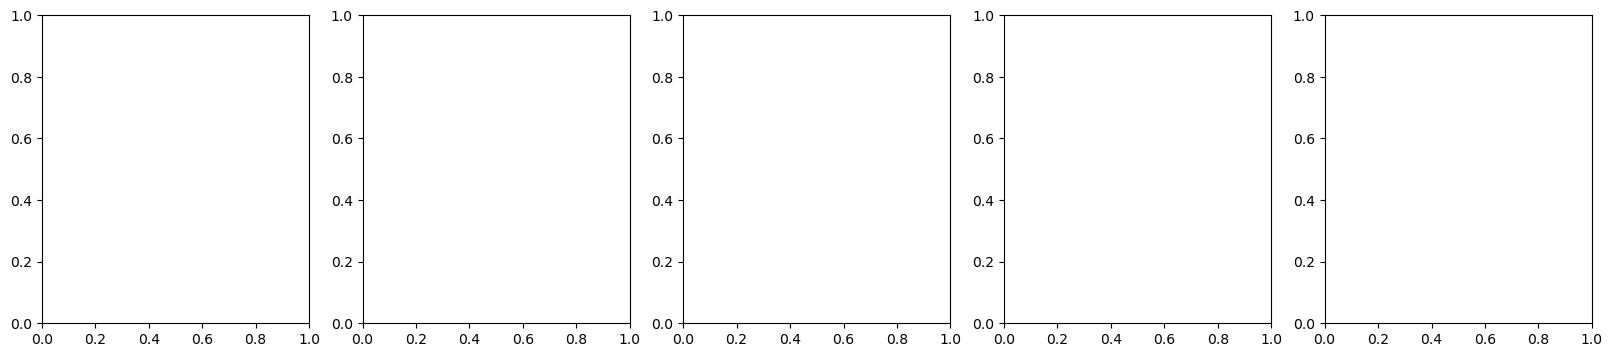

In [57]:
tile_number = (246, 289)

parent_dir = '/home/nick/astro/TileSlicer/'
cutout_dir = os.path.join(parent_dir, 'h5_files/')
os.makedirs(cutout_dir, exist_ok=True)
h5_filename = 'cutout_stacks_ugriz_lsb_200x200'
cutout_path = os.path.join(cutout_dir, h5_filename + f'_{tile_number[0]}_{tile_number[1]}.h5')
cutout = read_h5(cutout_path)

plot_cutout(cutout, band_dict)

In [53]:
cutout['images'].shape

(1, 5, 200, 200)

In [258]:
cutout['images'][6][0].shape

(200, 200)

In [262]:
tiles_five_bands[6]

(240, 291)

In [112]:
type(cutout['tile'][0])

numpy.int64

## VOSpace tile cuts

In [625]:
Client().copy('vos:cfis/tile.cuts', '/home/nick/astro/ssl-spencer/tiles.csv')
tiles = pd.read_csv('../tiles.csv', delimiter=r'\s+', header=None, names=['tile_numbers','ra_min','ra_max','dec_min','dec_max'])

In [626]:
tiles

,tile_numbers,ra_min,ra_max,dec_min,dec_max
0,0.240,-0.288675,0.288675,29.75,30.25
1,0.241,-0.290148,0.290148,30.25,30.75
2,0.242,-0.291658,0.291658,30.75,31.25
3,0.243,-0.293207,0.293207,31.25,31.75
4,0.244,-0.294795,0.294795,31.75,32.25
...,...,...,...,...,...
24346,620.240,357.668492,358.245842,29.75,30.25
24347,620.241,359.493404,360.073700,30.25,30.75
24348,621.240,358.245842,358.823192,29.75,30.25
24349,622.240,358.823192,359.400543,29.75,30.25


## Testing catalog matching

In [259]:
tile_nums = np.array([243,290])

# known_dwarfs = pd.read_csv('/home/nick/astro/TileSlicer/tables/all_known_dwarfs_processed.csv')
# known_dwarfs = known_dwarfs.loc[known_dwarfs['tile'] == str(tuple(tile_nums))].reset_index(drop=True)

condition = f"tile == '{str(tuple(tile_nums))}'"
gen = pd.read_csv(os.path.join('/home/nick/astro/TileSlicer/tables/', 'all_known_dwarfs_processed.csv'), chunksize=500, iterator=True)
known_dwarfs = pd.concat([x.query(condition) for x in gen]).reset_index(drop=True)


c_known_dwarfs = SkyCoord(known_dwarfs['ra'], known_dwarfs['dec'], unit='deg', frame='icrs')
detections = pd.read_csv('/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/fields/CFIS_LSB.243.290.r/sci_detections_mto_dt.csv')
detections.rename(columns={'X': 'x', 'Y': 'y'})
c_detections = SkyCoord(detections['ra'], detections['dec'], unit='deg', frame='icrs')

In [260]:
from astropy import units as u

max_sep = 15.0 * u.arcsec
idx, d2d, _ = c_known_dwarfs.match_to_catalog_3d(c_detections)
sep_constraint = d2d < max_sep
# known dwarfs that are also in the detections dataframe
df_known_matches = known_dwarfs[sep_constraint].reset_index(drop=True)
# known dwarfs that are not in the detections dataframe
df_known_unmatches = known_dwarfs[~sep_constraint].reset_index(drop=True)

df_detection_matches = detections.copy()
# detections that are also in the known dwarfs dataframe
df_detection_matches = df_detection_matches.loc[idx[sep_constraint]].reset_index(drop=True)

In [276]:
common_columns = detections.columns.intersection(df_known_unmatches.columns)
addition = detections.loc[detections['ID'] == 61616171]
master = pd.concat([detections, df_known_unmatches[common_columns], addition], ignore_index=True)
master['known'] = np.where(master['ID'].isin(df_detection_matches['ID']) |
                   master['ID'].isin(df_known_matches['ID']) |
                   master['ID'].isin(df_known_unmatches['ID']), 1, 0)
master['tile'] = f'{tuple(tile_nums)}'

In [280]:
addition

,Unnamed: 0,ID,X,Y,A,B,theta,total_flux,mu_max,mu_median,...,dec,re_arcsec,r_fwhm_arcsec,r_10_arcsec,r_90_arcsec,A_arcsec,B_arcsec,mag,mu,label


In [281]:
pd.DataFrame(columns=detections.columns)

,Unnamed: 0,ID,X,Y,A,B,theta,total_flux,mu_max,mu_median,...,dec,re_arcsec,r_fwhm_arcsec,r_10_arcsec,r_90_arcsec,A_arcsec,B_arcsec,mag,mu,label
